# CEBD 1260 Introduction to machine learning
## Home Credit
## Session 7 :



In [1]:
import numpy as np   # import numpy
import pandas as pd  # import pandas
import os
import gc   # for gabage collection
import seaborn as sns  # data visualization lib
import matplotlib.pyplot as plt
import glob 
%matplotlib inline
import datetime
import math
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
try:
   import cPickle as pickle
except:
   import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import ranksums
from bayes_opt import BayesianOptimization
import lightgbm as gbm

In [2]:
#Function to reduce dataframe memory footprint, reduce float and int to the minimum dtype
def reducemem(self):
    for c in self:
        if self[c].dtype =='int64':
            if self[c].max()<np.iinfo(np.int32).max and self[c].min()>np.iinfo(np.int32).min:
                self[c]=self[c].astype(np.int32)           
            if self[c].max()<np.iinfo(np.int16).max and self[c].min()>np.iinfo(np.int16).min:
                self[c]=self[c].astype(np.int16)
            if self[c].max()<np.iinfo(np.int8).max and self[c].min()>np.iinfo(np.int8).min:
                self[c]=self[c].astype(np.int8) 
                
        if self[c].dtype =='float64':
            if self[c].max()<np.finfo(np.float32).max and self[c].min()>np.finfo(np.float32).min:
                self[c]=self[c].astype(np.float32)           
            if self[c].max()<np.finfo(np.float16).max and self[c].min()>np.finfo(np.float16).min:
                self[c]=self[c].astype(np.float16)


In [22]:
#Super load file 
# We want to walk through the dir and get all file names once
DATA_PATH = ''
file_names = glob.glob(DATA_PATH+r"*.csv")
file_names

['application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv']

In [23]:
#loop to load evry csv in the file and reduce memory use
myDf=[]
for f in file_names:
    fstr=f.replace('C:\\Users\\kdavi\\Downloads\\home-credit-default-risk\\','')
    fstr=fstr.replace('.csv','')
    globals()['df_' + fstr] = pd.read_csv(f)
    print('df_' + fstr)
    mem_use = globals()['df_' + fstr].memory_usage().sum() / 1024**3 
    print('Memory usage of dataframe is {:.6f} GB'.format(mem_use))
    reducemem(globals()['df_' + fstr])
    mem_use2 = globals()['df_' + fstr].memory_usage().sum() / 1024**3
    print('Memory usage of dataframe after is {:.6f} GB'.format(mem_use2))
    print('We save {:.6f} GB'.format(mem_use-mem_use2))
    myDf.append('df_' + fstr)
    #print(globals()['df_' + fstr].head(1))
    #print(globals()['df_' + fstr].info())
    
gc.collect() 

df_application_train
Memory usage of dataframe is 0.279519 GB
Memory usage of dataframe after is 0.090214 GB
We save 0.189305 GB
df_bureau
Memory usage of dataframe is 0.217403 GB
Memory usage of dataframe after is 0.110300 GB
We save 0.107103 GB
df_bureau_balance
Memory usage of dataframe is 0.610201 GB
Memory usage of dataframe after is 0.330526 GB
We save 0.279675 GB
df_credit_card_balance
Memory usage of dataframe is 0.658089 GB
Memory usage of dataframe after is 0.282549 GB
We save 0.375540 GB
df_installments_payments
Memory usage of dataframe is 0.810945 GB
Memory usage of dataframe after is 0.304104 GB
We save 0.506841 GB
df_POS_CASH_balance
Memory usage of dataframe is 0.596127 GB
Memory usage of dataframe after is 0.232862 GB
We save 0.363265 GB
df_previous_application
Memory usage of dataframe is 0.460430 GB
Memory usage of dataframe after is 0.301769 GB
We save 0.158662 GB


12

In [24]:
# oder df to proceses data cleaning and agg loop 
myDf=['df_application_train',
 'df_bureau',
 'df_previous_application',
 'df_bureau_balance',
 'df_credit_card_balance',
 'df_installments_payments',
 'df_POS_CASH_balance']
myDf

['df_application_train',
 'df_bureau',
 'df_previous_application',
 'df_bureau_balance',
 'df_credit_card_balance',
 'df_installments_payments',
 'df_POS_CASH_balance']

In [25]:
#list and dictionnary for cleanin agg and merge process
TsDf=['df_bureau_balance','df_credit_card_balance','df_POS_CASH_balance']
KEY={'df_bureau':'SK_ID_CURR','df_bureau_balance':'SK_ID_BUREAU','df_credit_card_balance':'SK_ID_PREV','df_application_train':'',
     'df_installments_payments':'SK_ID_PREV','df_POS_CASH_balance':'SK_ID_PREV','df_previous_application':'SK_ID_CURR'}
Merge={'df_bureau_balance':'df_bureau','df_POS_CASH_balance':'df_previous_application',
      'df_installments_payments':'df_previous_application','df_credit_card_balance':'df_previous_application'}

gc.collect() 

40

In [26]:
# clean 'df_bureau' to 'df_previous_application'
# agg df_credit_card_balance df_installments_payments df_POS_CASH_balance and merge with df_previous_application
# agg df_bureau_balance and merge with df_bureau
for df in myDf:
    print(df)
    yourdf=globals()[df].copy()
    #rename column with name of df
    for c in yourdf:
        if c != 'SK_ID_CURR' and c != 'SK_ID_PREV' and c != 'TARGET'and c != 'SK_ID_BUREAU':
            yourdf= yourdf.rename(columns={c:df+"_"+c})
           
    # Identifying all categorical features
    features = [f for f in yourdf.columns.values if f not in ['TARGET']] 
    cat_features=[]

    for f in features:
        if str(yourdf[f].dtype) in ['int16','int32','int64']:
            cat_features.append(f)

    non_categ=[""]

    cat_features=list(set(cat_features)-set(non_categ))
    cat_features# no more object type column/didn't use get dummy yet

    # Fillna object colect num col
    objectcolumns=[]
    for f in yourdf:
        if str(yourdf[f].dtype) == 'object':
            objectcolumns.append(f)
    yourdf[objectcolumns]=yourdf[objectcolumns].replace(np.nan, 'UNKNOW', regex=True)
    print(objectcolumns)
    # Fillna num colect num col

    num_feat=[]
    for f in yourdf:
        if f not in objectcolumns:
            num_feat.append(f)


    for f in num_feat:
        yourdf[f].fillna(yourdf[f].median(),inplace=True)


    #lebal encoding dumm
    from sklearn.preprocessing import LabelEncoder
    labelencoders = {}

    for name in objectcolumns:
        if yourdf[name].nunique()<20:
            dumm=pd.get_dummies(yourdf[name],prefix=name)
            yourdf= pd.concat([yourdf,dumm], axis=1)
            #print(name)
            #print(dumm.head())
            
            
        yourdf[name]= yourdf[name].astype('str')
        labelencoder = LabelEncoder()
        labelencoder.fit( yourdf[[name]])
        yourdf[name] = labelencoder.transform( yourdf[[name]])
        labelencoders[name] = labelencoder
    
    
    #create dictionnary for group agg
    agg_dict = {}
    for i in yourdf.columns:
        if i in objectcolumns:
            agg_dict[i] = ['max','min','nunique']
        else:
            if i != 'SK_ID_CURR' and i != 'SK_ID_PREV' and i != 'SK_ID_BUREAU':
                agg_dict[i] = ['max','sum','mean']
                
    # aggregation of the df_bureau_balance','df_credit_card_balance','df_POS_CASH_balance , df_installments_payments
   
    
    if KEY[df]=="SK_ID_PREV" or KEY[df]=="SK_ID_BUREAU":
        if df in TsDf:
            yourdfgrp=yourdf.groupby(KEY[df],as_index=False).agg({**agg_dict})
            yourdfgrp.columns = ['{}{}'.format(x[0],x[1]) for x in yourdfgrp.columns.tolist()]
            yourdfgrp=yourdfgrp.reset_index(drop=True)  
            #yourdfgrp= yourdfgrp.rename(columns={"SK_ID_CURR":'SK_ID_CURR2'})

            yourdf1=yourdf[yourdf[df+'_MONTHS_BALANCE']==-1]
            yourdf1grp=yourdf1.groupby(KEY[df],as_index=False).agg({**agg_dict})
            yourdf1grp.columns = ['{}{}'.format(x[0],x[1]) for x in yourdf1grp.columns.tolist()]
            yourdf1grp=yourdf1grp.reset_index(drop=True)   
            for c in yourdf1grp:
                if c !=KEY[df]:
                    yourdf1grp= yourdf1grp.rename(columns={c:"Last_"+c})
            
            yourdf6=yourdf[yourdf[df+'_MONTHS_BALANCE']>=-6]
            yourdf6grp=yourdf6.groupby(KEY[df],as_index=False).agg({**agg_dict})
            yourdf6grp.columns = ['{}{}'.format(x[0],x[1]) for x in yourdf6grp.columns.tolist()]
            yourdf6grp=yourdf6grp.reset_index(drop=True)   
            for c in yourdf6grp:
                if c !=KEY[df]:
                    yourdf6grp= yourdf6grp.rename(columns={c:"Last_6_"+c})
            
            yourdf12=yourdf[yourdf[df+'_MONTHS_BALANCE']==-12]
            yourdf12grp=yourdf12.groupby(KEY[df],as_index=False).agg({**agg_dict})
            yourdf12grp.columns = ['{}{}'.format(x[0],x[1]) for x in yourdf12grp.columns.tolist()]
            yourdf12grp=yourdf12grp.reset_index(drop=True)   
            for c in yourdf12grp:
                if c !=KEY[df]:
                    yourdf12grp= yourdf12grp.rename(columns={c:"Last_12M_Diff"+c})
                    yourdf12grp["Last_12M_Diff"+c]=yourdf1grp["Last_"+c]-yourdf12grp["Last_12M_Diff"+c]
                    
                    
            yourdfgrp=pd.merge(yourdfgrp,yourdf1grp, on=KEY[df],how='left')
            yourdfgrp=yourdfgrp.reset_index(drop=True) 
            yourdfgrp=pd.merge(yourdfgrp,yourdf12grp, on=KEY[df],how='left')
            yourdfgrp=yourdfgrp.reset_index(drop=True) 
            yourdfgrp=pd.merge(yourdfgrp,yourdf6grp, on=KEY[df],how='left')
            yourdfgrp=yourdfgrp.reset_index(drop=True) 
            globals()[Merge[df]]= pd.merge(globals()[Merge[df]],yourdfgrp,on=KEY[df],how='left')
            globals()[Merge[df]]=globals()[Merge[df]].reset_index(drop=True)
            print(Merge[df])
            gc.collect() 
            del yourdfgrp, yourdf12grp , yourdf6grp , yourdf1grp
        else:
            yourdfgrp=yourdf.groupby(KEY[df],as_index=False).agg({**agg_dict})
            yourdfgrp.columns = ['{}{}'.format(x[0],x[1]) for x in yourdfgrp.columns.tolist()]
            yourdfgrp=yourdfgrp.reset_index(drop=True)   
            #yourdfgrp= yourdfgrp.rename(columns={"SK_ID_CURR":df+'SK_ID_CURR'})
            globals()[Merge[df]]= pd.merge(globals()[Merge[df]],yourdfgrp,on='SK_ID_PREV',how='left')
            globals()[Merge[df]]=globals()[Merge[df]].reset_index(drop=True)
            print(Merge[df])
            del yourdfgrp
            gc.collect() 
        del df
    else:
        globals()[df]=yourdf.copy()
        globals()[df]=globals()[df].reset_index(drop=True)
del yourdf
gc.collect() 


df_application_train
['df_application_train_NAME_CONTRACT_TYPE', 'df_application_train_CODE_GENDER', 'df_application_train_FLAG_OWN_CAR', 'df_application_train_FLAG_OWN_REALTY', 'df_application_train_NAME_TYPE_SUITE', 'df_application_train_NAME_INCOME_TYPE', 'df_application_train_NAME_EDUCATION_TYPE', 'df_application_train_NAME_FAMILY_STATUS', 'df_application_train_NAME_HOUSING_TYPE', 'df_application_train_OCCUPATION_TYPE', 'df_application_train_WEEKDAY_APPR_PROCESS_START', 'df_application_train_ORGANIZATION_TYPE', 'df_application_train_FONDKAPREMONT_MODE', 'df_application_train_HOUSETYPE_MODE', 'df_application_train_WALLSMATERIAL_MODE', 'df_application_train_EMERGENCYSTATE_MODE']
df_bureau
['df_bureau_CREDIT_ACTIVE', 'df_bureau_CREDIT_CURRENCY', 'df_bureau_CREDIT_TYPE']
df_previous_application
['df_previous_application_NAME_CONTRACT_TYPE', 'df_previous_application_WEEKDAY_APPR_PROCESS_START', 'df_previous_application_FLAG_LAST_APPL_PER_CONTRACT', 'df_previous_application_NAME_CASH_LOA

35

In [27]:
yourdf=[]
dumm=[]=[]
features=[]
cat_features=[]
objectcolumns=[]
agg_dict=[]
yourdfgrp=[]
yourdf1=[]
yourdf1grp=[]
yourdf6=[]
yourdf6grp=[]
yourdf12=[]
yourdf12grp=[]
gc.collect() 

56

In [28]:
#reduce memory


del df_bureau_balance , df_credit_card_balance , df_installments_payments , df_POS_CASH_balance
gc.collect() 
reducemem(df_application_train)
reducemem(df_previous_application)
reducemem(df_bureau)
gc.collect() 

0

In [29]:
# agg df_bureau and df_previous_application and merge with df_application_train
for df in myDf[1:]:    
    if KEY[df]=="SK_ID_CURR":
        yourdf=globals()[df].copy() 
        #create dictionnary for group agg
        agg_dict = {}
        for i in yourdf.columns:
                if i != 'SK_ID_CURR' and i != 'SK_ID_PREV' :
                    agg_dict[i] = ['max','sum','nunique']
                    
        yourdf=yourdf.reset_index(drop=True)        
        yourdfgrp=yourdf.groupby('SK_ID_CURR',as_index=False).agg({**agg_dict})
        yourdfgrp.columns = ['{}{}'.format(x[0],x[1]) for x in yourdfgrp.columns.tolist()]
        yourdfgrp=yourdfgrp.reset_index(drop=True)   
        df_application_train= pd.merge(df_application_train,yourdfgrp,on='SK_ID_CURR',how='left')
        print(df)
        gc.collect() 

df_bureau
df_previous_application


In [30]:
df_application_train=df_application_train.replace(-np.Inf, 0)
df_application_train=df_application_train.replace(np.Inf, 0)
df_application_train=df_application_train.replace(np.nan, 0)

In [31]:
del df_previous_application , df_bureau 
gc.collect() 
reducemem(df_application_train)
gc.collect() 

0

In [32]:
df = df_application_train.copy()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 2598 entries, SK_ID_CURR to Last_6_df_POS_CASH_balance_NAME_CONTRACT_STATUS_XNAmeannunique
dtypes: float16(2106), float32(347), int16(2), int32(18), int8(37), uint8(88)
memory usage: 1.7 GB


In [33]:
del df_application_train
gc.collect()

27

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 2598 entries, SK_ID_CURR to Last_6_df_POS_CASH_balance_NAME_CONTRACT_STATUS_XNAmeannunique
dtypes: float16(2106), float32(347), int16(2), int32(2), int8(141)
memory usage: 1.6 GB


In [35]:
for DF in myDf:
    print(DF)
    globals()[DF]=[]
gc.collect()    

27

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 2598 entries, SK_ID_CURR to Last_6_df_POS_CASH_balance_NAME_CONTRACT_STATUS_XNAmeannunique
dtypes: float16(2106), float32(347), int16(2), int32(2), int8(141)
memory usage: 1.6 GB


In [37]:
#....More Features
#
#
df['df_application_train_AMT_CREDIT * df_application_train_AMT_ANNUITY '] = df['df_application_train_AMT_CREDIT'] * df['df_application_train_AMT_ANNUITY']
#2
df['df_application_train_AMT_INCOME_TOTAL * df_application_train_AMT_ANNUITY'] = df['df_application_train_AMT_INCOME_TOTAL'] * df['df_application_train_AMT_ANNUITY']
#3
df['df_application_train_AMT_INCOME_TOTAL * df_application_train_DAYS_EMPLOYED'] = df['df_application_train_AMT_INCOME_TOTAL'] * df['df_application_train_DAYS_EMPLOYED']
#4
df['df_application_train_AMT_CREDIT * df_application_train_DAYS_EMPLOYED'] = df['df_application_train_AMT_CREDIT'] * df['df_application_train_DAYS_EMPLOYED']
#5
df['df_application_train_AMT_ANNUITY * df_application_train_DAYS_EMPLOYED'] = df['df_application_train_AMT_ANNUITY'] * df['df_application_train_DAYS_EMPLOYED']
#1
df['app missing'] = df.isnull().sum(axis = 1).values
#2
df['app EXT_SOURCE mean'] = df[['df_application_train_EXT_SOURCE_1', 'df_application_train_EXT_SOURCE_2', 
                                'df_application_train_EXT_SOURCE_3']].mean(axis = 1)
#3
df['app EXT_SOURCE std'] = df[['df_application_train_EXT_SOURCE_1', 'df_application_train_EXT_SOURCE_2',
                               'df_application_train_EXT_SOURCE_3']].std(axis = 1)
#4
df['app EXT_SOURCE prod'] = df['df_application_train_EXT_SOURCE_1'] * df['df_application_train_EXT_SOURCE_2'] * df['df_application_train_EXT_SOURCE_3']
#5
df['app EXT_SOURCE_1xEXT_SOURCE_2'] = df['df_application_train_EXT_SOURCE_1'] * df['df_application_train_EXT_SOURCE_2']
#6
df['app EXT_SOURCE_1xEXT_SOURCE_3'] = df['df_application_train_EXT_SOURCE_1'] * df['df_application_train_EXT_SOURCE_3']
#7
df['app EXT_SOURCE_2xEXT_SOURCE_3'] = df['df_application_train_EXT_SOURCE_2'] * df['df_application_train_EXT_SOURCE_3']
#8
df['app EXT_SOURCE_1xDAYS_EMPLOYED'] = df['df_application_train_EXT_SOURCE_1'] * df['df_application_train_DAYS_EMPLOYED']
#9 
df['app EXT_SOURCE_2xDAYS_EMPLOYED'] = df['df_application_train_EXT_SOURCE_2'] * df['df_application_train_DAYS_EMPLOYED']
#10
df['app EXT_SOURCE_3xDAYS_EMPLOYED'] = df['df_application_train_EXT_SOURCE_3'] * df['df_application_train_DAYS_EMPLOYED']

df['app EXT_SOURCE_1_div_DAYS_BIRTH'] = df['df_application_train_EXT_SOURCE_1'] / df['df_application_train_DAYS_BIRTH']
df['app EXT_SOURCE_2_div_DAYS_BIRTH'] = df['df_application_train_EXT_SOURCE_2'] / df['df_application_train_DAYS_BIRTH']
df['app EXT_SOURCE_3_div_DAYS_BIRTH'] = df['df_application_train_EXT_SOURCE_3'] / df['df_application_train_DAYS_BIRTH']

df['app AMT_CREDITminusT_GOODS_PRICE'] = df['df_application_train_AMT_CREDIT'] - df['df_application_train_AMT_GOODS_PRICE']
df['app AMT_CREDIT_div_AMT_GOODS_PRICE'] = df['df_application_train_AMT_CREDIT'] / df['df_application_train_AMT_GOODS_PRICE']
df['app AMT_CREDIT_div_AMT_ANNUITY'] = df['df_application_train_AMT_CREDIT'] / df['df_application_train_AMT_ANNUITY']
df['app AMT_CREDIT_div_AMT_INCOME_TOTAL'] = df['df_application_train_AMT_CREDIT'] / df['df_application_train_AMT_INCOME_TOTAL']


df['df_application_train_AMT_INCOME_TOTAL / 12 - df_application_train_AMT_ANNUITY'] = df['df_application_train_AMT_INCOME_TOTAL'] / 12. - df['df_application_train_AMT_ANNUITY']
#2
df['df_application_train_AMT_INCOME_TOTAL / df_application_train_AMT_ANNUITY'] = df['df_application_train_AMT_INCOME_TOTAL'] / df['df_application_train_AMT_ANNUITY']
#3
df['df_application_train_AMT_INCOME_TOTAL - df_application_train_AMT_GOODS_PRICE'] = df['df_application_train_AMT_INCOME_TOTAL'] - df['df_application_train_AMT_GOODS_PRICE']
#4
df['df_application_train_AMT_INCOME_TOTAL / df_application_train_CNT_CHILDREN'] = df['df_application_train_AMT_INCOME_TOTAL'] / (1 + df['df_application_train_CNT_CHILDREN'])
df['df_application_train_AMT_CREDIT - df_application_train_AMT_GOODS_PRICE'] = df['df_application_train_AMT_CREDIT'] - df['df_application_train_AMT_GOODS_PRICE']
#2
df['df_application_train_AMT_CREDIT / df_application_train_AMT_GOODS_PRICE'] = df['df_application_train_AMT_CREDIT'] / df['df_application_train_AMT_GOODS_PRICE']
#3
df['df_application_train_AMT_CREDIT / df_application_train_AMT_ANNUITY'] = df['df_application_train_AMT_CREDIT'] / df['df_application_train_AMT_ANNUITY']
#4
df['df_application_train_AMT_CREDIT/ df_application_train_AMT_INCOME_TOTAL'] = df['df_application_train_AMT_CREDIT'] / df['df_application_train_AMT_INCOME_TOTAL']
df['df_application_train_AMT_GOODS_PRICE'] = df['df_application_train_AMT_GOODS_PRICE'] \
                    .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
df['df_application_train_AMT_GOODS_PRICE'] = df['df_application_train_AMT_GOODS_PRICE'] \
                    .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
df['df_application_train_OWN_CAR_AGE / df_application_train_DAYS_BIRTH'] = df['df_application_train_OWN_CAR_AGE'] / df['df_application_train_DAYS_BIRTH']
df['df_application_train_OWN_CAR_AGE / df_application_train_DAYS_EMPLOYED'] = df['df_application_train_OWN_CAR_AGE'] / df['df_application_train_DAYS_EMPLOYED']
df['df_application_train_OWN_CAR_AGE / df_application_train_DAYS_BIRTH'] = df['df_application_train_OWN_CAR_AGE'] / df['df_application_train_DAYS_BIRTH']
df['df_application_train_OWN_CAR_AGE / df_application_train_DAYS_EMPLOYED'] = df['df_application_train_OWN_CAR_AGE'] / df['df_application_train_DAYS_EMPLOYED']
df['df_application_train_DAYS_EMPLOYED - df_application_train_DAYS_BIRTH'] = df['df_application_train_DAYS_EMPLOYED'] - df['df_application_train_DAYS_BIRTH']
df['df_application_train_DAYS_EMPLOYED / df_application_train_DAYS_BIRTH'] = df['df_application_train_DAYS_EMPLOYED'] / df['df_application_train_DAYS_BIRTH']
df['df_application_train_CNT_CHILDREN / df_application_train_CNT_FAM_MEMBERS'] = df['df_application_train_CNT_CHILDREN'] / df['df_application_train_CNT_FAM_MEMBERS']
df['df_bureau_AMT_CREDIT_SUMsum - df_bureau_AMT_CREDIT_SUM_DEBTsum'] = df['df_bureau_AMT_CREDIT_SUMsum'] - df['df_bureau_AMT_CREDIT_SUM_DEBTsum']
df['df_bureau_AMT_CREDIT_SUMsum - df_bureau_AMT_CREDIT_SUM_LIMITsum'] = df['df_bureau_AMT_CREDIT_SUMsum'] - df['df_bureau_AMT_CREDIT_SUM_LIMITsum']
df['df_bureau_AMT_CREDIT_SUMsum - df_bureau_AMT_CREDIT_SUM_OVERDUEsum'] = df['df_bureau_AMT_CREDIT_SUMsum'] - df['df_bureau_AMT_CREDIT_SUM_OVERDUEsum']
df['df_bureau_DAYS_CREDITsum - df_bureau_CREDIT_DAY_OVERDUEsum'] = df['df_bureau_DAYS_CREDITsum'] - df['df_bureau_CREDIT_DAY_OVERDUEsum']
df['df_bureau_DAYS_CREDITsum - df_bureau_DAYS_CREDIT_ENDDATEsum'] = df['df_bureau_DAYS_CREDITsum'] - df['df_bureau_DAYS_CREDIT_ENDDATEsum']
df['df_bureau_DAYS_CREDITsum - df_bureau_DAYS_ENDDATE_FACTsum'] = df['df_bureau_DAYS_CREDITsum'] - df['df_bureau_DAYS_ENDDATE_FACTsum']
df['df_bureau_DAYS_CREDIT_ENDDATEsum - df_bureau_DAYS_ENDDATE_FACTsum'] = df['df_bureau_DAYS_CREDIT_ENDDATEsum'] - df['df_bureau_DAYS_ENDDATE_FACTsum']
df['df_bureau_DAYS_CREDIT_UPDATEsum - df_bureau_DAYS_CREDIT_ENDDATEsum'] = df['df_bureau_DAYS_CREDIT_UPDATEsum'] - df['df_bureau_DAYS_CREDIT_ENDDATEsum']
df['df_previous_application_AMT_APPLICATIONsum / df_previous_application_AMT_CREDITsum'] = df['df_previous_application_AMT_APPLICATIONsum'] / df['df_previous_application_AMT_CREDITsum']
df['df_previous_application_AMT_APPLICATIONsum - df_previous_application_AMT_CREDITsum'] = df['df_previous_application_AMT_APPLICATIONsum'] - df['df_previous_application_AMT_CREDITsum']
df['df_previous_application_AMT_APPLICATIONsum - df_previous_application_AMT_GOODS_PRICEsum'] = df['df_previous_application_AMT_APPLICATIONsum'] - df['df_previous_application_AMT_GOODS_PRICEsum']
df['df_previous_application_AMT_GOODS_PRICEsum - df_previous_application_AMT_CREDITsum'] = df['df_previous_application_AMT_GOODS_PRICEsum'] - df['df_previous_application_AMT_CREDITsum']
df['df_previous_application_DAYS_FIRST_DRAWINGsum - df_previous_application_DAYS_FIRST_DUEsum'] = df['df_previous_application_DAYS_FIRST_DRAWINGsum'] - df['df_previous_application_DAYS_FIRST_DUEsum']
df['df_previous_application_DAYS_TERMINATIONsum less -500'] = (df['df_previous_application_DAYS_TERMINATIONsum'] < -500).astype(int)
df['df_credit_card_balance_SK_DPDsumsum - df_credit_card_balance_MONTHS_BALANCEsumsum'] = df['df_credit_card_balance_SK_DPDsumsum'] - df['df_credit_card_balance_MONTHS_BALANCEsumsum']
df['df_credit_card_balance_SK_DPD_DEFsumsum - df_credit_card_balance_MONTHS_BALANCEsumsum'] = df['df_credit_card_balance_SK_DPD_DEFsumsum'] - df['df_credit_card_balance_MONTHS_BALANCEsumsum']
df['df_credit_card_balance_SK_DPDsumsum - df_credit_card_balance_SK_DPD_DEFsumsum'] = df['df_credit_card_balance_SK_DPDsumsum'] - df['df_credit_card_balance_SK_DPD_DEFsumsum']
df['df_credit_card_balance_AMT_TOTAL_RECEIVABLEsumsum - df_credit_card_balance_AMT_RECIVABLEsumsum'] = df['df_credit_card_balance_AMT_TOTAL_RECEIVABLEsumsum'] - df['df_credit_card_balance_AMT_RECIVABLEsumsum']
df['df_credit_card_balance_AMT_TOTAL_RECEIVABLEsumsum - df_credit_card_balance_AMT_RECEIVABLE_PRINCIPALsumsum'] = df['df_credit_card_balance_AMT_TOTAL_RECEIVABLEsumsum'] - df['df_credit_card_balance_AMT_RECEIVABLE_PRINCIPALsumsum']
df['df_credit_card_balance_AMT_RECIVABLEsumsum - df_credit_card_balance_AMT_RECEIVABLE_PRINCIPALsumsum'] = df['df_credit_card_balance_AMT_RECIVABLEsumsum'] - df['df_credit_card_balance_AMT_RECEIVABLE_PRINCIPALsumsum']
df['df_credit_card_balance_AMT_BALANCEsumsum - df_credit_card_balance_AMT_RECIVABLEsumsum'] = df['df_credit_card_balance_AMT_BALANCEsumsum'] - df['df_credit_card_balance_AMT_RECIVABLEsumsum']
df['df_credit_card_balance_AMT_BALANCEsumsum - df_credit_card_balance_AMT_RECEIVABLE_PRINCIPALsumsum'] = df['df_credit_card_balance_AMT_BALANCEsumsum'] - df['df_credit_card_balance_AMT_RECEIVABLE_PRINCIPALsumsum']
df['df_credit_card_balance_AMT_BALANCEsumsum - df_credit_card_balance_AMT_TOTAL_RECEIVABLEsumsum'] = df['df_credit_card_balance_AMT_BALANCEsumsum'] - df['df_credit_card_balance_AMT_TOTAL_RECEIVABLEsumsum']
df['df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum - df_credit_card_balance_AMT_DRAWINGS_ATM_CURRENTsumsum'] = df['df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum'] - df['df_credit_card_balance_AMT_DRAWINGS_ATM_CURRENTsumsum']
df['df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum - df_credit_card_balance_AMT_DRAWINGS_OTHER_CURRENTsumsum'] = df['df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum'] - df['df_credit_card_balance_AMT_DRAWINGS_OTHER_CURRENTsumsum']
df['df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum - df_credit_card_balance_AMT_DRAWINGS_POS_CURRENTsumsum'] = df['df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum'] - df['df_credit_card_balance_AMT_DRAWINGS_POS_CURRENTsumsum']





In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 2659 entries, SK_ID_CURR to df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum - df_credit_card_balance_AMT_DRAWINGS_POS_CURRENTsumsum
dtypes: float16(2115), float32(389), float64(6), int16(2), int32(4), int64(2), int8(141)
memory usage: 1.7 GB


In [39]:
df=df.replace(-np.Inf, 0)
df=df.replace(np.Inf, 0)
df=df.replace(np.nan, 0)

In [54]:
#loop to create financial ratio 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2#for categorical variables chi2 test
from sklearn.feature_selection import f_classif
import time

start = time.time()

y_train=df['TARGET']
X_train=df.drop(columns=['TARGET'])
bestfeat=pd.DataFrame()
fvalue_selector = SelectKBest(f_classif, k=min(X_train.shape[1],500))
FX_kbest = fvalue_selector.fit_transform(X_train, y_train)
bestlist=[]
gc.collect()
for b in (zip(fvalue_selector.get_support(),X_train.columns)):
    if b[0]==True and b[1]!='TARGET':
        bestlist.append(b[1])
        
var=bestlist

for opp in range(1,6):   
    print(opp)
    i=0

    for c in var[:-1]:
        i=i+1
        Newfeat=pd.DataFrame()
        for cc in var[i:]:
            if opp ==1:
                Newfeat[c+"_plus_"+cc]=X_train[c]+X_train[cc]
            if opp ==2:
                Newfeat[c+"_minus_"+cc]=X_train[c]-X_train[cc]
            if opp ==3:
                Newfeat[c+"_multi_"+cc]=X_train[c]*X_train[cc]
            if opp ==4:
                Newfeat[c+"_div_"+cc]=X_train[c]/X_train[cc]
            if opp ==5:
                Newfeat[c+"_div_"+cc]=X_train[c]/X_train[cc]
        if i > 1:
            Newfeat=pd.concat([Newfeat,bestfeat],axis=1)
        
        Newfeat=Newfeat.replace(-np.Inf, 0)
        Newfeat=Newfeat.replace(np.Inf, 0)
        Newfeat=Newfeat.replace(np.nan, 0) 
        fvalue_selector = SelectKBest(f_classif, k=min(Newfeat.shape[1],100))
        FX_kbest = fvalue_selector.fit_transform(Newfeat, y_train)
        bestlist=[]
        gc.collect()
        end = time.time()

        for b in (zip(fvalue_selector.get_support(),Newfeat.columns)):
            if b[0]==True and b[1]!='TARGET':
                bestlist.append(b[1])

        bestfeat=Newfeat[bestlist].copy()
        end2 = time.time()

        gc.collect()
    X_train=pd.concat([X_train,bestfeat],axis=1) 
    for cols in bestfeat:
        print(cols)
    bestfeat=pd.DataFrame()
    if opp ==4:
        fvalue_selector = SelectKBest(f_classif, k=min(X_train.shape[1],600))
        FX_kbest = fvalue_selector.fit_transform(X_train, y_train)
        bestlist=[]
        gc.collect()
        for b in (zip(fvalue_selector.get_support(),X_train.columns)):
            if b[0]==True and b[1]!='TARGET':
                bestlist.append(b[1])
        var=bestlist
end = time.time()
print(end - start)


1
app EXT_SOURCE_2xEXT_SOURCE_3_plus_app EXT_SOURCE_2_div_DAYS_BIRTH
app EXT_SOURCE_2xEXT_SOURCE_3_plus_app EXT_SOURCE_3_div_DAYS_BIRTH
app EXT_SOURCE_2xEXT_SOURCE_3_plus_df_application_train_OWN_CAR_AGE / df_application_train_DAYS_BIRTH
app EXT_SOURCE_2xEXT_SOURCE_3_plus_df_application_train_OWN_CAR_AGE / df_application_train_DAYS_EMPLOYED
app EXT_SOURCE_1xEXT_SOURCE_3_plus_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE_1xEXT_SOURCE_3_plus_app EXT_SOURCE_2_div_DAYS_BIRTH
app EXT_SOURCE_1xEXT_SOURCE_3_plus_app EXT_SOURCE_3_div_DAYS_BIRTH
app EXT_SOURCE_1xEXT_SOURCE_3_plus_df_application_train_OWN_CAR_AGE / df_application_train_DAYS_BIRTH
app EXT_SOURCE_1xEXT_SOURCE_3_plus_df_application_train_OWN_CAR_AGE / df_application_train_DAYS_EMPLOYED
app EXT_SOURCE_1xEXT_SOURCE_2_plus_app EXT_SOURCE_1xEXT_SOURCE_3
app EXT_SOURCE_1xEXT_SOURCE_2_plus_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE_1xEXT_SOURCE_2_plus_app EXT_SOURCE_2_div_DAYS_BIRTH
app EXT_SOURCE_1xEXT_SOURCE_2_plus_app EXT_SOURCE_3_di

app EXT_SOURCE_2xEXT_SOURCE_3_multi_app AMT_CREDIT_div_AMT_GOODS_PRICE
app EXT_SOURCE_2xEXT_SOURCE_3_multi_app AMT_CREDIT_div_AMT_ANNUITY
app EXT_SOURCE_2xEXT_SOURCE_3_multi_df_application_train_AMT_CREDIT / df_application_train_AMT_GOODS_PRICE
app EXT_SOURCE_2xEXT_SOURCE_3_multi_df_application_train_AMT_CREDIT / df_application_train_AMT_ANNUITY
app EXT_SOURCE_1xEXT_SOURCE_3_multi_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE_1xEXT_SOURCE_3_multi_app EXT_SOURCE_2_div_DAYS_BIRTH
app EXT_SOURCE_1xEXT_SOURCE_2_multi_app EXT_SOURCE_1xEXT_SOURCE_3
app EXT_SOURCE_1xEXT_SOURCE_2_multi_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE_1xEXT_SOURCE_2_multi_app EXT_SOURCE_3_div_DAYS_BIRTH
app EXT_SOURCE prod_multi_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE prod_multi_app EXT_SOURCE_2_div_DAYS_BIRTH
app EXT_SOURCE prod_multi_app EXT_SOURCE_3_div_DAYS_BIRTH
app EXT_SOURCE prod_multi_app AMT_CREDIT_div_AMT_GOODS_PRICE
app EXT_SOURCE prod_multi_app AMT_CREDIT_div_AMT_ANNUITY
app EXT_SOURCE prod_multi_df

5
app EXT_SOURCE prod_multi_df_application_train_AMT_CREDIT / df_application_train_AMT_GOODS_PRICE_div_app EXT_SOURCE mean_multi_app EXT_SOURCE prod
app EXT_SOURCE prod_multi_app AMT_CREDIT_div_AMT_GOODS_PRICE_div_app EXT_SOURCE mean_multi_app EXT_SOURCE prod
app EXT_SOURCE_2xEXT_SOURCE_3_multi_df_application_train_AMT_CREDIT / df_application_train_AMT_GOODS_PRICE_div_app EXT_SOURCE mean_multi_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE_2xEXT_SOURCE_3_multi_app AMT_CREDIT_div_AMT_GOODS_PRICE_div_app EXT_SOURCE mean_multi_app EXT_SOURCE_2xEXT_SOURCE_3
app EXT_SOURCE mean_minus_df_application_train_AMT_CREDIT / df_application_train_AMT_GOODS_PRICE_div_app EXT_SOURCE mean_minus_df_application_train_OWN_CAR_AGE / df_application_train_DAYS_BIRTH
app EXT_SOURCE mean_minus_df_application_train_AMT_CREDIT / df_application_train_AMT_GOODS_PRICE_div_app EXT_SOURCE mean_minus_df_application_train_OWN_CAR_AGE / df_application_train_DAYS_EMPLOYED
app EXT_SOURCE mean_minus_df_application_train_AMT_

In [62]:
X_train=pd.concat([X_train,y_train],axis=1)

In [63]:
X_train.to_csv('df_application_train_new1.csv' ,index=False)

In [ ]:
df_application_train_2=df_application_train_2.replace(-np.Inf, 0)
df_application_train_2=df_application_train_2.replace(np.Inf, 0)
df_application_train_2=df_application_train_2.replace(np.nan, 0)
reducemem(df_application_train_2)

gc.collect()

In [ ]:
df_application_train_2.info()

In [ ]:
df_application_train_2.to_csv('df_application_train_2.csv',index=False)

In [ ]:
gc.collect()

In [ ]:
df=df_application_train_2.copy()
df.info()


# Step 2 

In [38]:
df=[]
gc.collect()


34397

In [3]:
df= pd.read_csv('df_application_train_new1.csv')

In [4]:
def trim(st):
    st=st.strip(" ")
    st=st.replace(',', '')
    st=st.replace(' ', '_')
    st=st.replace(':', '_')
    return st
df = df.rename(columns=lambda x: trim(x))
gc.collect()

31

In [5]:
df=df.replace(-np.Inf, 0)
df=df.replace(np.Inf, 0)
df=df.replace(np.nan, 0)
gc.collect()

0

In [6]:
reducemem(df)
gc.collect()

0

In [7]:
##shortcut
#df= pd.read_csv('df_application_train_4.csv')
#reducemem(df)
#gc.collect()
#df.to_csv('df_application_train_4.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 3159 entries, SK_ID_CURR to TARGET
dtypes: float16(2641), float32(369), int16(2), int32(3), int8(144)
memory usage: 2.0 GB


In [9]:
gc.collect()

27

In [10]:
def corr_feature_with_target(feature, target):
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff, p]

In [11]:
# Removing empty features
nun = df.nunique()
empty = list(nun[nun <= 1].index)

df.drop(empty, axis = 1, inplace = True)
print('After removing empty features there are {0:d} features'.format(df.shape[1]))

# Removing features with the same distribution on 0 and 1 classes
corr = pd.DataFrame(index = ['diff', 'p'])
ind = df[df['TARGET'].notnull()].index

for c in df.columns.drop('TARGET'):
    corr[c] = corr_feature_with_target(df.loc[ind, c], df.loc[ind, 'TARGET'])

corr = corr.T
corr['diff_norm'] = abs(corr['diff'] / df.mean(axis = 0))

to_del_1 = corr[((corr['diff'] == 0) & (corr['p'] > .05))].index
to_del_2 = corr[((corr['diff_norm'] < .5) & (corr['p'] > .05))].drop(to_del_1).index
to_del = list(to_del_1) + list(to_del_2)
if 'SK_ID_CURR' in to_del:
    to_del.remove('SK_ID_CURR')

df.drop(to_del, axis = 1, inplace = True)
print('After removing features with the same distribution on 0 and 1 classes there are {0:d} features'.format(df.shape[1]))

# Removing features with not the same distribution on train and test dfsets
corr_test = pd.DataFrame(index = ['diff', 'p'])
target = df['TARGET'].notnull().astype(int)

for c in df.columns.drop('TARGET'):
    corr_test[c] = corr_feature_with_target(df[c], target)

corr_test = corr_test.T
corr_test['diff_norm'] = abs(corr_test['diff'] / df.mean(axis = 0))

bad_features = corr_test[((corr_test['p'] < .05) & (corr_test['diff_norm'] > 1))].index
bad_features = corr.loc[bad_features][corr['diff_norm'] == 0].index

df.drop(bad_features, axis = 1, inplace = True)
print('After removing features with not the same distribution on train and test dfsets there are {0:d} features'.format(df.shape[1]))

del corr, corr_test
gc.collect()

# Removing features not interesting for classifier
clf = LGBMClassifier(random_state = 0)
train_index = df[df['TARGET'].notnull()].index
train_columns = df.drop('TARGET', axis = 1).columns

score = 1
new_columns = []
while score > .6:
    train_columns = train_columns.drop(new_columns)
    clf.fit(df.loc[train_index, train_columns], df.loc[train_index, 'TARGET'])
    f_imp = pd.Series(clf.feature_importances_, index = train_columns)
    score = roc_auc_score(df.loc[train_index, 'TARGET'], 
                          clf.predict_proba(df.loc[train_index, train_columns])[:, 1])
    new_columns = f_imp[f_imp > 0].index

df.drop(train_columns, axis = 1, inplace = True)
print('After removing features not interesting for classifier there are {0:d} features'.format(df.shape[1]))


After removing empty features there are 3055 features
After removing features with the same distribution on 0 and 1 classes there are 2164 features
After removing features with not the same distribution on train and test dfsets there are 2164 features
After removing features not interesting for classifier there are 1814 features


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 1814 entries, SK_ID_CURR to TARGET
dtypes: float16(1416), float32(314), int16(2), int32(3), int8(79)
memory usage: 1.2 GB


In [14]:
df.to_csv('df_application_train_new2.csv',index=False)

In [15]:
# create a dictionnary save it and load it before loading part 3 csv
CTdict = {}
for i in df.columns: 
    CTdict[i] = df[i].dtypes
    
import pickle
f = open("ctdict2.pkl","wb")
pickle.dump(CTdict,f)
f.close()

f = open("dict2.txt","w")
f.write( str(dict) )
f.close()

# Part 3 LGBM

In [3]:
# START
# IMPORT DATA TYPE DICTIONARY
with open('ctdict.pkl', 'rb') as handle:
    cvsdict = pickle.load(handle)


In [4]:
##shortcut
df= pd.read_csv('df_application_train_3.csv',dtype=cvsdict)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 1452 entries, SK_ID_CURR to df_credit_card_balance_AMT_DRAWINGS_CURRENTsumsum_-_df_credit_card_balance_AMT_DRAWINGS_POS_CURRENTsumsum
dtypes: float16(1078), float32(284), float64(6), int64(84)
memory usage: 1.1 GB


In [6]:
df=df.replace(-np.Inf, 0)
df=df.replace(np.Inf, 0)
df=df.replace(np.nan, 0)
def trim(st):
    st=st.strip(" ")
    st=st.replace(',', '')
    st=st.replace(' ', '_')
    st=st.replace(':', '_')
    return st
df = df.rename(columns=lambda x: trim(x))
reducemem(df)
gc.collect()




25

In [3]:
# START
# IMPORT DATA TYPE DICTIONARY csv

with open('ctdict2.pkl', 'rb') as handle:
    cvsdict = pickle.load(handle)

df = pd.read_csv('df_application_train_new2.csv',dtype=cvsdict)
df=df.replace(-np.Inf, 0)
df=df.replace(np.Inf, 0)
df=df.replace(np.nan, 0)
def trim(st):
    st=st.strip(" ")
    st=st.replace(',', '')
    st=st.replace(' ', '_')
    st=st.replace(':', '_')
    return st
df = df.rename(columns=lambda x: trim(x))
reducemem(df)
gc.collect()
y_train=[]
X_train=[]

def allsample(df):
    y_train = df['TARGET']
    X_train = df.drop(columns=['TARGET'])
    del  df
    return(X_train , y_train)

def equaltargetsplit(df):    
    x1=df[df['TARGET']==1]
    x0=df[df['TARGET']==0]
    x0=x0.sample(n=x1.shape[0], replace=True, random_state=1)
    x=pd.concat([x1,x0],axis=0).reset_index(drop=True)
    y_train=x['TARGET']
    X_train=x.drop(columns=['TARGET'])
    del df,x1,x0,x
    return(X_train , y_train)

#call your sampling method 
X_train , y_train = allsample(df)
#X_train , y_train = equaltargetsplit(df)

gc.collect()

0

In [11]:
import optuna
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

def objective(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(X_train,y_train, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    # 2. Suggest values of the hyperparameters using a trial object.
   
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 50, 500),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 80),
        "max_depth":trial.suggest_int('max_depth', 10, 40),
        "max_bin":trial.suggest_int('max_bin', 500, 3000),}
        #"n_estimators": trial.suggest_int('n_estimators', 6000, 50000),}
        
        
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2020-03-24 00:37:42,619] Finished trial#0 resulted in value: 0.9195868779104556. Current best value is 0.9195868779104556 with parameters: {'lambda_l1': 5.5039730529768824e-08, 'lambda_l2': 2.725540027751314e-05, 'num_leaves': 372, 'feature_fraction': 0.9777235129835546, 'bagging_fraction': 0.7514656375933639, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 18, 'max_bin': 623}.
[I 2020-03-24 00:41:38,740] Finished trial#1 resulted in value: 0.9175446811831733. Current best value is 0.9195868779104556 with parameters: {'lambda_l1': 5.5039730529768824e-08, 'lambda_l2': 2.725540027751314e-05, 'num_leaves': 372, 'feature_fraction': 0.9777235129835546, 'bagging_fraction': 0.7514656375933639, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 18, 'max_bin': 623}.
[I 2020-03-24 00:44:26,551] Finished trial#2 resulted in value: 0.9180519784593772. Current best value is 0.9195868779104556 with parameters: {'lambda_l1': 5.5039730529768824e-08, 'lambda_l2': 2.725540027751314e-05

KeyboardInterrupt: 

In [4]:
import types
gbm.Booster.feature_name
gbm.Booster.feature_name = df.columns
gbm.Booster.feature_name = types.MethodType(lambda self: gbm.Booster.feature_name, gbm.Booster)

In [34]:
def cv_scores(df, num_folds, params, stratified = False, verbose = -1, 
              save_train_prediction = False, train_prediction_file_name = 'train_prediction.csv',
              save_test_prediction = True, test_prediction_file_name = 'test_prediction.csv'):
    warnings.simplefilter('ignore')
    
    clf = LGBMClassifier(**params)

    # Divide in training/validation and test data
    train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    # Create arrays and dataframes to store results
    train_pred = np.zeros(train_df.shape[0])
    train_pred_proba = np.zeros(train_df.shape[0])

    test_pred = np.zeros(train_df.shape[0])
    test_pred_proba = np.zeros(train_df.shape[0])
    
    prediction = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    df_feature_importance = pd.DataFrame(index = feats)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 500)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction += \
                clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits

        df_feature_importance[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    roc_auc_train = roc_auc_score(train_df['TARGET'], train_pred_proba)
    precision_train = precision_score(train_df['TARGET'], train_pred, average = None)
    recall_train = recall_score(train_df['TARGET'], train_pred, average = None)
    
    roc_auc_test = roc_auc_score(train_df['TARGET'], test_pred_proba)
    precision_test = precision_score(train_df['TARGET'], test_pred, average = None)
    recall_test = recall_score(train_df['TARGET'], test_pred, average = None)
    print('Full AUC score %.6f' % roc_auc_test)
    
    df_feature_importance.fillna(0, inplace = True)
    df_feature_importance['mean'] = df_feature_importance.mean(axis = 1)
    
    # Write prediction files
    if save_train_prediction:
        df_prediction = train_df[['SK_ID_CURR', 'TARGET']]
        df_prediction['Prediction'] = test_pred_proba
        df_prediction.to_csv(train_prediction_file_name, index = False)
        del df_prediction
        gc.collect()

    if save_test_prediction:
        df_prediction = test_df[['SK_ID_CURR']]
        df_prediction['TARGET'] = prediction
        df_prediction.to_csv(test_prediction_file_name, index = False)
        del df_prediction
        gc.collect()
    
    return df_feature_importance, \
           [roc_auc_train, roc_auc_test,
            precision_train[0], precision_test[0], precision_train[1], precision_test[1],
            recall_train[0], recall_test[0], recall_train[1], recall_test[1], 0]


In [6]:
def display_folds_importances(feature_importance_df_, n_folds = 5):
    n_columns = 3
    n_rows = (n_folds + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i in range(n_folds):
        sns.barplot(x = i, y = 'index', data = feature_importance_df_.reset_index().sort_values(i, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns])
    sns.barplot(x = 'mean', y = 'index', data = feature_importance_df_.reset_index().sort_values('mean', ascending = False).head(20), 
                    ax = axes[n_rows - 1, n_columns - 1])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [7]:
scores_index = [
    'roc_auc_train', 'roc_auc_test', 
    'precision_train_0', 'precision_test_0', 
    'precision_train_1', 'precision_test_1', 
    'recall_train_0', 'recall_test_0', 
    'recall_train_1', 'recall_test_1', 
    'LB'
]
scores = pd.DataFrame(index = scores_index)

In [8]:
lgbm_params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 8,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1
}

In [27]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
  
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['bagging_freq'] = int(params['bagging_freq'])
    params['max_bin'] = int(params['max_bin'])
    params['n_estimators'] = int(params['n_estimators'])
    
    clf = LGBMClassifier(**params, nthread = 4)
    train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)


    folds = KFold(n_splits = 2, shuffle = True, random_state = 1001)
        
    test_pred_proba = np.zeros(train_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = False, early_stopping_rounds = 100)

        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    return roc_auc_score(train_df['TARGET'], test_pred_proba)

In [28]:
params = {'colsample_bytree': (0.7, 0.95),
          'learning_rate': (.005, .025), 
          'num_leaves': (30, 40), 
          'subsample': (0.7, 0.95), 
          'max_depth': (6, 11), 
          'reg_alpha': (.02, .07), 
          'reg_lambda': (.05, .1), 
          'min_split_gain': (.01, .06),
          'min_child_weight': (35, 45)}


In [29]:
params = {'colsample_bytree': (0.75, 1),
          'learning_rate': (.005, .025), 
          'num_leaves': (25, 200), 
          'subsample': (0.75, 1), 
          'max_depth': (10, 25), 
          'reg_alpha': (.025, .05), 
          'reg_lambda': (.055, .08), 
          'min_split_gain': (.01, .05),
          'min_child_weight': (20, 60),
          'max_bin': (100,2000),
          'n_estimators': (5000,50000),
          'feature_fraction':( 0.5,1),
          'bagging_fraction':(0.5,1),
          'bagging_freq': (3,10),
         }

In [31]:
gc.collect()
bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points = 5 , n_iter =5)


|   iter    |  target   | baggin... | baggin... | colsam... | featur... | learni... |  max_bin  | max_depth | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7836   |  0.6664   |  4.461    |  0.7529   |  0.6578   |  0.01903  |  1.554e+0 |  19.96    |  57.57    |  0.02933  |  2.594e+0 |  99.76    |  0.0404   |  0.07247  |  0.7851   |
|  2        |  0.7838   |  0.8329   |  9.577    |  0.9349   |  0.8015   |  0.005356 |  1.362e+0 |  20.75    |  29.99    |  0.0395   |  2.391e+0 |  157.5    |  0.02868  |  0.05651  |  0.7699   |
|  3        |  0.785    |  0.9848   |  4.629    |  0.8495   |  0.6351   |  0.02136  |  1.226e+0 |  13.63    |  29.47    |  0.01705  |  6.253e+0 |  28.41    |  0.04625  |  0.06432  |  0.9251   |
|  4        |  0.7841   |  0.5

In [35]:
best_params = bo.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])
best_params['max_bin'] = int(best_params['max_bin'])
best_params['n_estimators'] = int(best_params['n_estimators'])
feature_importance, scor = cv_scores(df,5 , best_params, test_prediction_file_name = 'prediction_1.csv')

Starting LightGBM. Train shape: (246008, 1814), test shape: (61503, 1814)
Fold 0 started at Tue Mar 24 07:05:17 2020
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1733]	training's auc: 0.913409	training's binary_logloss: 0.185214	valid_1's auc: 0.783141	valid_1's binary_logloss: 0.238398
Fold  0 AUC : 0.783141
Fold 1 started at Tue Mar 24 07:37:23 2020
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1925]	training's auc: 0.92016	training's binary_logloss: 0.181904	valid_1's auc: 0.785013	valid_1's binary_logloss: 0.236699
Fold  1 AUC : 0.785013
Fold 2 started at Tue Mar 24 08:11:09 2020
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1735]	training's auc: 0.91287	training's binary_logloss: 0.185393	valid_1's auc: 0.789949	valid_1's binary_logloss: 0.237751
Fold  2 AUC : 0.789949
Fold 3 started at Tue Mar 24 08:42:35 2020
Training until 

In [36]:
step = 'Bayesian optimization for new set'
scores[step] = scor



scores.loc['LB', step] = .797
scores.T

,roc_auc_train,roc_auc_test,precision_train_0,precision_test_0,precision_train_1,precision_test_1,recall_train_0,recall_test_0,recall_train_1,recall_test_1,LB
Bayesian optimization for new set,0.931333,0.788298,0.929681,0.922269,0.954374,0.572554,0.999412,0.997121,0.139968,0.043872,0.797


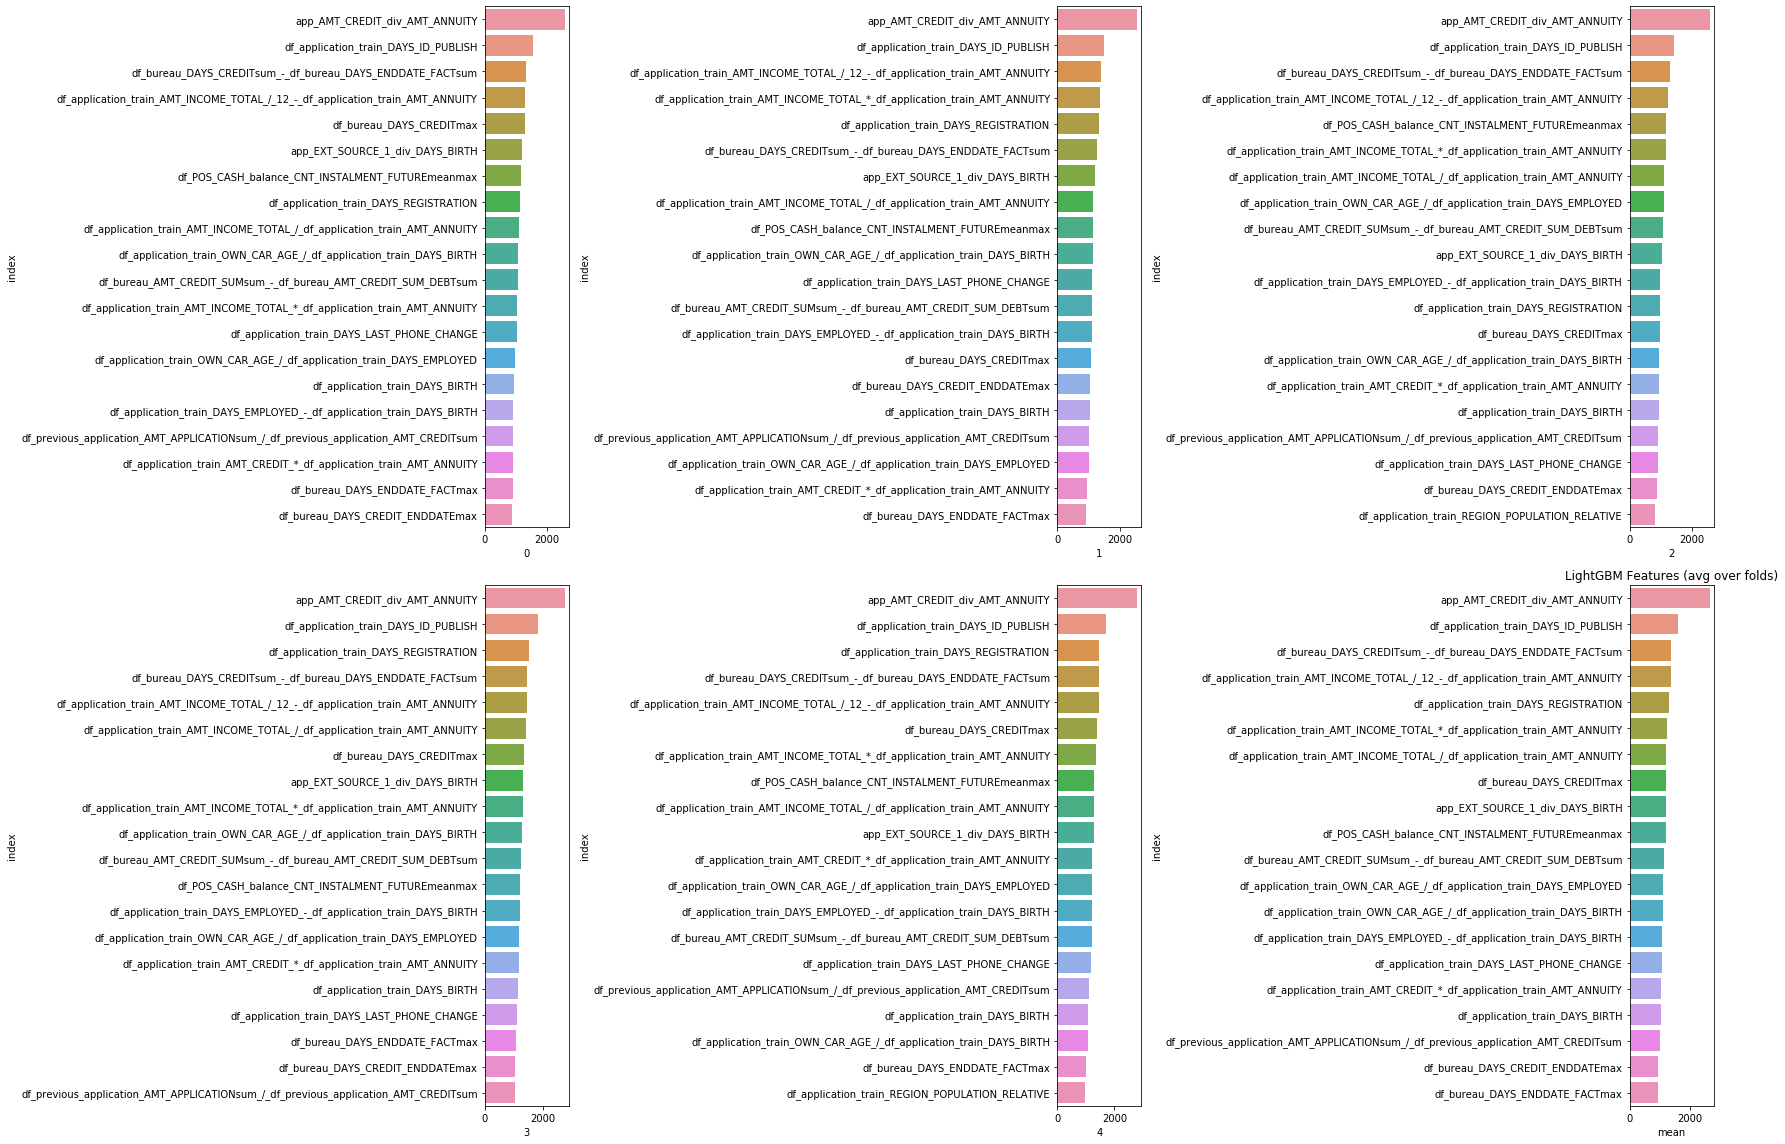

In [37]:
display_folds_importances(feature_importance)

In [38]:
feature_importance[feature_importance['mean'] == 0].shape

(193, 6)

In [39]:
feature_importance.sort_values('mean', ascending = False).head(20)

,0,1,2,3,4,mean
app_AMT_CREDIT_div_AMT_ANNUITY,2560,2566,2573,2753,2793,2649.0
df_application_train_DAYS_ID_PUBLISH,1554,1515,1418,1819,1720,1605.2
df_bureau_DAYS_CREDITsum_-_df_bureau_DAYS_ENDDATE_FACTsum,1317,1273,1299,1464,1471,1364.8
df_application_train_AMT_INCOME_TOTAL_/_12_-_df_application_train_AMT_ANNUITY,1295,1392,1225,1436,1459,1361.4
df_application_train_DAYS_REGISTRATION,1134,1346,974,1523,1474,1290.2
df_application_train_AMT_INCOME_TOTAL_*_df_application_train_AMT_ANNUITY,1042,1357,1167,1314,1368,1249.6
df_application_train_AMT_INCOME_TOTAL_/_df_application_train_AMT_ANNUITY,1104,1157,1122,1426,1292,1220.2
df_bureau_DAYS_CREDITmax,1271,1094,968,1342,1406,1216.2
app_EXT_SOURCE_1_div_DAYS_BIRTH,1195,1198,1048,1324,1278,1208.6
df_POS_CASH_balance_CNT_INSTALMENT_FUTUREmeanmax,1159,1138,1184,1226,1292,1199.8


In [40]:
for c in df:
    print(c)

SK_ID_CURR
df_application_train_NAME_CONTRACT_TYPE
df_application_train_CODE_GENDER
df_application_train_FLAG_OWN_CAR
df_application_train_FLAG_OWN_REALTY
df_application_train_CNT_CHILDREN
df_application_train_AMT_INCOME_TOTAL
df_application_train_AMT_CREDIT
df_application_train_NAME_TYPE_SUITE
df_application_train_NAME_INCOME_TYPE
df_application_train_NAME_EDUCATION_TYPE
df_application_train_NAME_HOUSING_TYPE
df_application_train_REGION_POPULATION_RELATIVE
df_application_train_DAYS_BIRTH
df_application_train_DAYS_EMPLOYED
df_application_train_DAYS_REGISTRATION
df_application_train_DAYS_ID_PUBLISH
df_application_train_OWN_CAR_AGE
df_application_train_FLAG_EMP_PHONE
df_application_train_FLAG_WORK_PHONE
df_application_train_FLAG_PHONE
df_application_train_OCCUPATION_TYPE
df_application_train_CNT_FAM_MEMBERS
df_application_train_REGION_RATING_CLIENT
df_application_train_REGION_RATING_CLIENT_W_CITY
df_application_train_WEEKDAY_APPR_PROCESS_START
df_application_train_HOUR_APPR_PROCESS_START

df_previous_application_NAME_TYPE_SUITE_Group_of_peoplenunique
df_previous_application_NAME_TYPE_SUITE_Other_Anunique
df_previous_application_NAME_TYPE_SUITE_Other_Bnunique
df_previous_application_NAME_TYPE_SUITE_Spouse_partnernunique
df_previous_application_NAME_TYPE_SUITE_UNKNOWmax
df_previous_application_NAME_TYPE_SUITE_UNKNOWsum
df_previous_application_NAME_TYPE_SUITE_UNKNOWnunique
df_previous_application_NAME_TYPE_SUITE_Unaccompaniedmax
df_previous_application_NAME_TYPE_SUITE_Unaccompaniednunique
df_previous_application_NAME_CLIENT_TYPE_Newmax
df_previous_application_NAME_CLIENT_TYPE_Newsum
df_previous_application_NAME_CLIENT_TYPE_Newnunique
df_previous_application_NAME_CLIENT_TYPE_Refreshedmax
df_previous_application_NAME_CLIENT_TYPE_Refreshedsum
df_previous_application_NAME_CLIENT_TYPE_Refreshednunique
df_previous_application_NAME_CLIENT_TYPE_Repeatermax
df_previous_application_NAME_CLIENT_TYPE_Repeatersum
df_previous_application_NAME_CLIENT_TYPE_Repeaternunique
df_previous_appl

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 1814 entries, SK_ID_CURR to TARGET
dtypes: float16(1416), float32(314), int16(2), int32(3), int8(79)
memory usage: 1.2 GB
